<a href="https://colab.research.google.com/github/prometneus/Nonribosomal-Peptides/blob/main/NonRibosomalPeptides_ML_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

     |████████████████████████████████| 69.2MB 41kB/s 


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import catboost

from matplotlib import pyplot as plt
# %matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, cross_val_score, 
train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, 
confusion_matrix, f1_score, make_scorer
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
!wget https://raw.githubusercontent.com/prometneus/Nonribosomal-Peptides/main/data/FullDB.csv

--2021-07-06 12:56:47--  https://raw.githubusercontent.com/prometneus/Nonribosomal-Peptides/main/data/FullDB.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 612651 (598K) [text/plain]
Saving to: ‘FullDB.csv’

FullDB.csv          100%[===================>] 598.29K  --.-KB/s    in 0.02s   

2021-07-06 12:56:47 (31.1 MB/s) - ‘FullDB.csv’ saved [612651/612651]



In [ ]:
data = pd.read_csv("FullDB.csv")
data.head(10)

,spec,Sequence,8A-signature,stachelhaus-code
0,pro,YRELDERANRLAHLLAAHGVGPERIVALALPRSVDLVVAVLAVLKA...,LWHTFDVSAQESFAAQAGEHNHYGPTETHVVTAH,DVQFAAHVV-
1,pro,TYKELNESANRLARHLRKKGVMRQEPVAIMMERSTEFVTGILGILK...,LFEAFDVCYQESVSITAGEHNHYGPSETHVVSAY,DVQVIAHVV-
2,pro,TYRELHERSNQLARFLREKGVKKESIIGIMMERSVEMIVGILGILK...,LFTTFDVCYQESSFITAGEHNHYGPSETHVVTTY,DVQSIAHVV-
3,pro,SYRRLDQLSSSLAEELIGHGVGVEMTIPVLLEKTCWTPVAMLAVLK...,AHLSWDIPVTDLLLVLAGEIQGYGPAECSLVSTV,DITLVAGLV-
4,pro,TYRELNKAANRLARHLRMKGVVRQEPVAIMMERSAAFITGVLGILK...,LFEAFDVCYQESFLIAAGEHNHYGPSETHVVSTY,DVQFIAHVV-
5,pro,TYRELWAHSSFFARQLQRYGVTRGTPVAVCLDRSRWSIAVILGVLL...,SHHSFDVSIYETFLVLGGEINGYGPAEATICGVG,DVYFVGGIC-
6,pro,TYQQLNQKANQLAHSLQCLGVTPDSLVAICLERSLDMAVAILGTLK...,LHHAFDVSYHEAILITAGEYNFYGPSEADLVTAY,DVHIIAFLV-
7,pro,SYTELERVSSTWARQLQKQGISQGSWVLFCFEKSRLAVVSMIAILK...,AAYSFDISIADTVLIFTGEYNVYGPAENTLITTA,DIAVITVLI-
8,pro,TYSELDRQSDELAGWLRQQRLPAESLVAVLAPRSCQTIVAFLGILK...,VSPTFDVSLWETVFFSSGDHNAYGPTENGIQSTI,DVWVFSAIQ-
9,pro,TYYELNYRANQLAHYLQSLGVGSDALVGLCVERSLEMVIGLLGILK...,LWHAFDVSFQETFLITAGEHNHYGPSESHLATSF,DVQFIAHLA-


In [ ]:
data.dropna()
data.isna().sum()

spec                0
Sequence            0
8A-signature        0
stachelhaus-code    0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1354 entries, 0 to 1353
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   spec              1354 non-null   object
 1   Sequence          1354 non-null   object
 2   8A-signature      1354 non-null   object
 3   stachelhaus-code  1354 non-null   object
dtypes: object(4)
memory usage: 42.4+ KB


In [ ]:
# refuse = ['dht', 'dab', 'pip', 'trp', 'ala-b', 'abu', 'ser-thr', 'sal', 'lys-b',
#           'alaninol', 'vol', 'd-lyserg', 'tcl', '3-me-glu', 'dpg', '4ppro',
#           'bmt', 'ala-d', 'aeo', 'hiv', 'his', 'phg', 'spec', 'pip']
# for i, elem in enumerate(refuse):
#   data.drop(data[data['spec'] == refuse[i]].index, inplace=True)

# data.head(10)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1354 entries, 0 to 1353
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   spec              1354 non-null   object
 1   Sequence          1354 non-null   object
 2   8A-signature      1354 non-null   object
 3   stachelhaus-code  1354 non-null   object
dtypes: object(4)
memory usage: 42.4+ KB


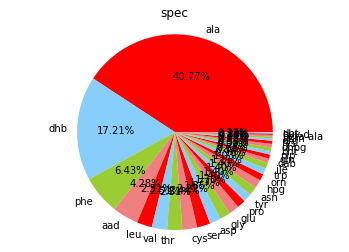

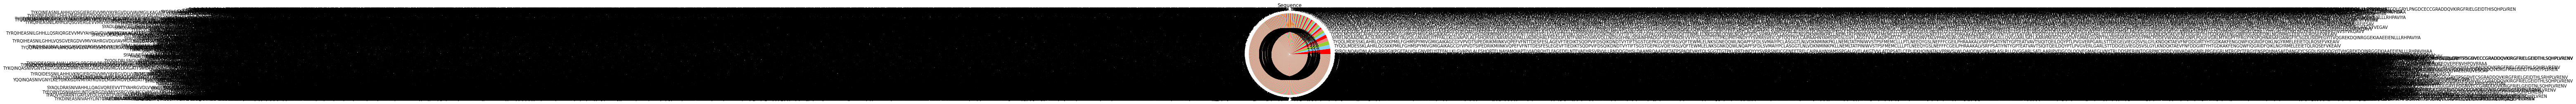

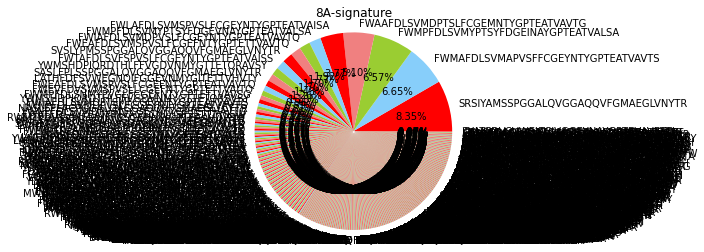

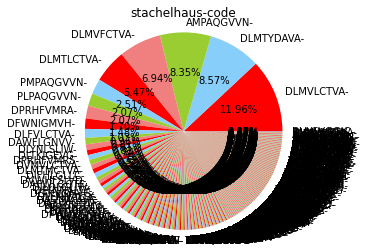

In [ ]:
for ctg in data:
  plot,figure = plt.subplots() 
  colors = ['red', 'lightskyblue', 'yellowgreen', 'lightcoral']
  lbl = list(data[ctg].value_counts().index)
  figure.pie(data[ctg].value_counts(normalize=True).tolist(),
             colors = colors, labels=lbl,autopct='%1.2f%%')
  figure.axis('equal') 
  figure.set_title(ctg)
  plt.show()

In [ ]:
X = data['8A-signature']
y = data['spec']
X.head(10)

0    LWHTFDVSAQESFAAQAGEHNHYGPTETHVVTAH
1    LFEAFDVCYQESVSITAGEHNHYGPSETHVVSAY
2    LFTTFDVCYQESSFITAGEHNHYGPSETHVVTTY
3    AHLSWDIPVTDLLLVLAGEIQGYGPAECSLVSTV
4    LFEAFDVCYQESFLIAAGEHNHYGPSETHVVSTY
5    SHHSFDVSIYETFLVLGGEINGYGPAEATICGVG
6    LHHAFDVSYHEAILITAGEYNFYGPSEADLVTAY
7    AAYSFDISIADTVLIFTGEYNVYGPAENTLITTA
8    VSPTFDVSLWETVFFSSGDHNAYGPTENGIQSTI
9    LWHAFDVSFQETFLITAGEHNHYGPSESHLATSF
Name: 8A-signature, dtype: object

In [ ]:
print(pd.unique(y))
print(len(pd.unique(y)))

['pro' 'phe' 'asn' 'gln' 'tyr' 'val' 'orn' 'leu' 'ile' 'cys' 'glu' 'lys'
 'asp' 'thr' 'trp' 'gly' 'ala' 'ser' 'dhb' 'aad' 'pip' 'bht' 'hpg' 'dhpg'
 'beta-ala' 'dab' 'arg' 'horn' 'hyv-d' 'dht']
30


In [ ]:
uarr = []
for line in X:
  uarr += set(line)
uarr = set(uarr)
uarr

{'-',
 'A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y'}

In [ ]:
uarr_dum = pd.get_dummies(list(uarr))
uarr_dum['W']

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    1
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
Name: W, dtype: uint8

In [ ]:
result = []
for line in X:
  new_line = []
  for char in line:
    new_line.append(uarr_dum[char])
  result.append(new_line)

In [ ]:
np.array(result).shape

(1354, 34, 21)

In [ ]:
_X_ = np.array(result)
_X_

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
labels = ['spec']
y = np.array(y)
y.tolist()

['pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',


In [ ]:
_X_.shape, y.shape

((1354, 34, 21), (1354,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(_X_, y, train_size = 0.8)

In [ ]:
X_train.shape, y_train.shape

((1083, 34, 21), (1083,))

In [ ]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_test =  X_test.reshape(X_test.shape[0],-1)

# Naive Bayes

Cross Validation accuracy scores: [0.85321101 0.79816514 0.8440367  0.84259259 0.83333333 0.81481481
 0.83333333 0.78703704 0.86111111 0.74074074]
Cross Validation accuracy: 0.821 +/- 0.035
Naive Bayes accuracy: 0.819
              precision    recall  f1-score   support

         aad       0.94      0.89      0.92        19
         ala       0.99      0.96      0.98       106
         arg       1.00      1.00      1.00         1
         asn       1.00      0.67      0.80         3
         asp       1.00      0.67      0.80         3
         cys       0.60      0.60      0.60         5
         dab       1.00      1.00      1.00         3
         dhb       0.98      1.00      0.99        45
        dhpg       0.00      0.00      0.00         5
         dht       0.50      1.00      0.67         1
         gln       1.00      1.00      1.00         1
         glu       0.33      0.25      0.29         4
         gly       1.00      0.50      0.67         6
        horn       1.00  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


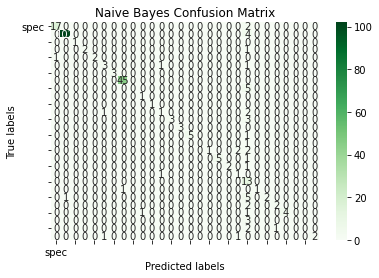

In [ ]:
# Create a Gaussian classifier
nb_model = GaussianNB()

kf = KFold(n_splits=10)
results = cross_val_score(nb_model, X_train, y_train, cv=kf)
print('Cross Validation accuracy scores: %s' % results)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(results),
                                                    np.std(results)))
print('===================')

nb_model.fit(X_train, y_train)

nb_pred = nb_model.predict(X_test)

print('Naive Bayes accuracy:', round(accuracy_score(y_test, nb_pred), 3))
print(classification_report(y_test, nb_model.predict(X_test)))

cm_nb =  confusion_matrix(y_test, nb_pred)

ax = plt.subplot()
sns.heatmap(cm_nb, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Naive Bayes Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

# Catboost

In [ ]:
cat = CatBoostClassifier()
params = {  
    "max_depth": [7, 8, 9],
    "learning_rate": [0.15, 0.2, 0.3, 0.4],
    "iterations": [65, 70, 75]
}

search_cat = GridSearchCV(estimator=cat, param_grid = params, n_jobs=-1)
kf = KFold(n_splits=10)
results = cross_val_score(search_cat, X_train, y_train, cv=kf)
print('Cross Validation accuracy scores: %s' % results)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(results),
                                                    np.std(results)))
print('===================')
search_cat.fit(X_train, y_train)
search_cat.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0:	learn: 1.4770094	total: 316ms	remaining: 21.8s
1:	learn: 1.3366836	total: 483ms	remaining: 16.4s
2:	learn: 1.2042645	total: 645ms	remaining: 14.4s
3:	learn: 1.1048254	total: 807ms	remaining: 13.3s
4:	learn: 1.0183971	total: 978ms	remaining: 12.7s
5:	learn: 0.9486338	total: 1.14s	remaining: 12.1s
6:	learn: 0.8751209	total: 1.3s	remaining: 11.7s
7:	learn: 0.8255527	total: 1.46s	remaining: 11.3s
8:	learn: 0.7837914	total: 1.63s	remaining: 11s
9:	learn: 0.7472030	total: 1.79s	remaining: 10.8s
10:	learn: 0.7107666	total: 1.96s	remaining: 10.5s
11:	learn: 0.6756702	total: 2.12s	remaining: 10.2s
12:	learn: 0.6555496	total: 2.28s	remaining: 9.99s
13:	learn: 0.6284527	total: 2.44s	remaining: 9.76s
14:	learn: 0.6054884	total: 2.61s	remaining: 9.58s
15:	learn: 0.5975433	total: 2.77s	remaining: 9.36s
16:	learn: 0.5718699	total: 2.94s	remaining: 9.16s
17:	learn: 0.5445023	total: 3.1s	remaining: 8.95s
18:	learn: 0.5254882	total: 3.26s	remaining: 8.76s
19:	learn: 0.5081185	total: 3.42s	remaining: 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0:	learn: 1.5917014	total: 184ms	remaining: 11.8s
1:	learn: 1.4594946	total: 346ms	remaining: 10.9s
2:	learn: 1.3345417	total: 510ms	remaining: 10.5s
3:	learn: 1.2390535	total: 671ms	remaining: 10.2s
4:	learn: 1.1581763	total: 834ms	remaining: 10s
5:	learn: 1.0766482	total: 1s	remaining: 9.84s
6:	learn: 1.0019622	total: 1.18s	remaining: 9.75s
7:	learn: 0.9549963	total: 1.34s	remaining: 9.55s
8:	learn: 0.9093365	total: 1.52s	remaining: 9.45s
9:	learn: 0.8650996	total: 1.68s	remaining: 9.27s
10:	learn: 0.8293065	total: 1.85s	remaining: 9.1s
11:	learn: 0.8048322	total: 2.02s	remaining: 8.9s
12:	learn: 0.7739329	total: 2.19s	remaining: 8.75s
13:	learn: 0.7492528	total: 2.35s	remaining: 8.56s
14:	learn: 0.7314359	total: 2.51s	remaining: 8.37s
15:	learn: 0.7063182	total: 2.67s	remaining: 8.19s
16:	learn: 0.6823220	total: 2.84s	remaining: 8.02s
17:	learn: 0.6665725	total: 3s	remaining: 7.84s
18:	learn: 0.6424675	total: 3.18s	remaining: 7.69s
19:	learn: 0.6219178	total: 3.34s	remaining: 7.51s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


KeyboardInterrupt: ignored

In [ ]:
print(classification_report(y_test, search_cat.best_estimator_.predict(X_test)))

# Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

Cross Validation accuracy scores: [0.86238532 0.8440367  0.8440367  0.86111111 0.86111111 0.84259259
 0.86111111 0.86111111 0.88888889 0.7962963 ]
Cross Validation accuracy: 0.852 +/- 0.023


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Best Parameters:
 {'C': 1, 'penalty': 'l2'}
Logistic Regression accuracy: 0.878
              precision    recall  f1-score   support

         aad       1.00      0.89      0.94        19
         ala       0.97      0.97      0.97       106
         arg       1.00      1.00      1.00         1
         asn       0.60      1.00      0.75         3
         asp       0.50      0.67      0.57         3
         bht       0.00      0.00      0.00         0
         cys       0.62      1.00      0.77         5
         dab       1.00      1.00      1.00         3
         dhb       0.98      1.00      0.99        45
        dhpg       1.00      1.00      1.00         5
         dht       0.00      0.00      0.00         1
         gln       1.00      1.00      1.00         1
         glu       0.50      0.50      0.50         4
         gly       0.86      1.00      0.92         6
        horn       1.00      1.00      1.00         3
         hpg       1.00      1.00      1.00         6
 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(0, 0.5, 'spec')]

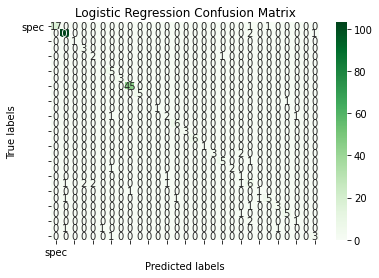

In [ ]:
log_grid = {'C': [1, 10, 100], 
                 'penalty': ['l1', 'l2']}

log_estimator = LogisticRegression(solver='liblinear')

log_model = GridSearchCV(estimator=log_estimator, 
                  param_grid=log_grid, 
                  cv=3,
                  scoring='accuracy')

kf = KFold(n_splits=10)
results = cross_val_score(log_model, X_train, y_train, cv=kf)
print('Cross Validation accuracy scores: %s' % results)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(results), 
                                                    np.std(results)))
print('===================')


log_model.fit(X_train, y_train)

print("Best Parameters:\n", log_model.best_params_)

# Select best log model
best_log = log_model.best_estimator_

# Make predictions using the optimised parameters
log_pred = best_log.predict(X_test)

print('Logistic Regression accuracy:', round(accuracy_score(y_test, log_pred), 3))
print(classification_report(y_test, best_log.predict(X_test)))

cm_log =  confusion_matrix(y_test, log_pred)

ax = plt.subplot()
sns.heatmap(cm_log, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Logistic Regression Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360)

# Random Forest

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

Cross Validation accuracy scores: [0.86451613 0.83870968 0.85806452 0.83870968 0.8516129  0.88961039
 0.83116883]
Cross Validation accuracy: 0.853 +/- 0.018


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Best Parameters:
 {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 0.51, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 53}
Random Forest accuracy: 0.863
              precision    recall  f1-score   support

         aad       1.00      0.89      0.94        19
         ala       0.96      0.94      0.95       106
         arg       0.50      1.00      0.67         1
         asn       0.43      1.00      0.60         3
         asp       0.40      0.67      0.50         3
         bht       0.00      0.00      0.00         0
         cys       0.62      1.00      0.77         5
         dab       0.75      1.00      0.86         3
         dhb       0.98      1.00      0.99        45
        dhpg       1.00      1.00      1.00         5
         dht       0.50      1.00      0.67         1
         gln       1.00      1.00      1.00         1
         glu       0.50      0.25      0.33         4
         gly       0.86      1.00      0.92         6
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


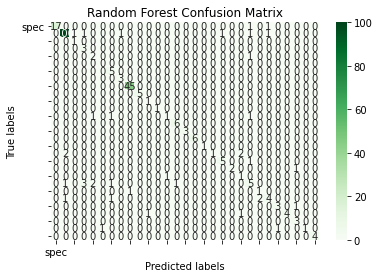

In [ ]:
# Hyperparameters search grid 
rf_param_grid = {'bootstrap': [False, True],
         'n_estimators': [51, 52, 53, 54],
         'max_features': [0.51, 0.52, 0.53],
         'min_samples_leaf': [3, 4, 5],
         'min_samples_split': [2, 3],
         'class_weight' : ["balanced"]
        }

# Instantiate random forest classifier
rf_estimator = RandomForestClassifier(random_state=0)

# Create the GridSearchCV object
rf_model = GridSearchCV(estimator=rf_estimator, param_grid=rf_param_grid, cv=3, scoring='accuracy')


kf = KFold(n_splits=7)
results = cross_val_score(log_model, X_train, y_train, cv=kf)
print('Cross Validation accuracy scores: %s' % results)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(results),np.std(results)))
print('===================')

# Fine-tune the hyperparameters
rf_model.fit(X_train, y_train)

print("Best Parameters:\n", rf_model.best_params_)

# Get the best model
rf_model_best = rf_model.best_estimator_

# Make predictions using the optimised parameters
rf_pred = rf_model_best.predict(X_test)

print('Random Forest accuracy:', round(accuracy_score(y_test, rf_pred), 3))
print(classification_report(y_test, rf_model_best.predict(X_test)))

cm_rf = confusion_matrix(y_test, rf_pred)

ax = plt.subplot()
sns.heatmap(cm_rf, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Random Forest Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

# Supporting Vector Machines

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

Cross Validation accuracy scores: [0.90825688 0.82568807 0.8440367  0.85185185 0.84259259 0.85185185
 0.84259259 0.86111111 0.89814815 0.81481481]
Cross Validation accuracy: 0.854 +/- 0.028


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Best Parameters:
 {'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'linear'}
SVM accuracy: 0.889


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         aad       1.00      0.89      0.94        19
         ala       0.98      0.97      0.98       106
         arg       1.00      1.00      1.00         1
         asn       0.43      1.00      0.60         3
         asp       0.50      0.67      0.57         3
         bht       0.00      0.00      0.00         0
         cys       0.71      1.00      0.83         5
         dab       1.00      1.00      1.00         3
         dhb       0.98      1.00      0.99        45
        dhpg       1.00      1.00      1.00         5
         dht       0.00      0.00      0.00         1
         gln       1.00      1.00      1.00         1
         glu       0.67      0.50      0.57         4
         gly       1.00      0.83      0.91         6
        horn       1.00      1.00      1.00         3
         hpg       1.00      1.00      1.00         6
       hyv-d       1.00      1.00      1.00         1
         ile       1.00    

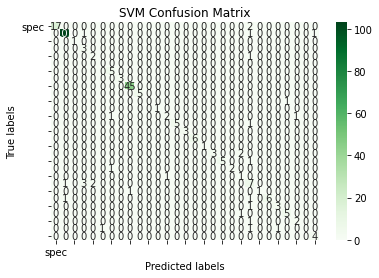

In [ ]:
# Parameter grid
svm_param_grid = {'C': [0.1, 1, 10, 100], 
                  'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10], 
                  "kernel": ["linear", "rbf", "poly"], 
                  "decision_function_shape" : ["ovo", "ovr"]} 

# Create SVM grid search classifier
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)

kf = KFold(n_splits=10)
results = cross_val_score(svm_grid, X_train, y_train, cv=kf)
print('Cross Validation accuracy scores: %s' % results)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(results),np.std(results)))
print('===================')


# Train the classifier
svm_grid.fit(X_train, y_train)

print("Best Parameters:\n", svm_grid.best_params_)

# Select best svc
best_svc = svm_grid.best_estimator_

# Make predictions using the optimised parameters
svm_pred = best_svc.predict(X_test)

print('SVM accuracy:', round(accuracy_score(y_test, svm_pred), 3))
print(classification_report(y_test, best_svc.predict(X_test)))

cm_svm =  confusion_matrix(y_test, svm_pred)

ax = plt.subplot()
sns.heatmap(cm_svm, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('SVM Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

# Check for commit updates